# Assignment 2

**Submission deadline: last lab session before or on Thursday, 26.03.2020**

**Points: 6 + 1 bonus points**

## Submission instructions
The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment2_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restar and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook with your instructor using his `cs.uni.wroc.pl` email

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D` matrix.

Text(0, 0.5, 'X[1]')

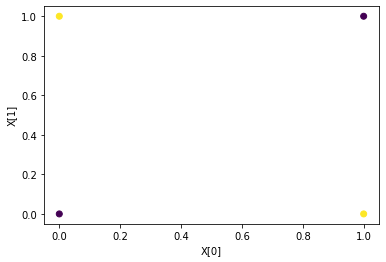

In [0]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1],
    ], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array(
    [[0],
     [1],
     [1],
     [0],
    ], dtype=np.float32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0], )
plt.xlabel('X[0]')
plt.ylabel('X[1]')

# Problem 1 [2p]

Fill in the details of a forward pass, then manually set the weights and biases in the network to solve the 2D XOR task defined above.

In [0]:
def sigmoid(x):
    #return TODO
    return 1/(1 + np.exp(-x))

class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((in_features, num_hidden), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((num_hidden, 1), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # TODO Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.normal(0, 0.5, self.W1.shape)
        self.b1 = np.random.normal(0, 0.5, self.b1.shape)
        self.W2 = np.random.normal(0, 0.5, self.W2.shape)
        self.b2 = np.random.normal(0, 0.5, self.b2.shape)

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # n = X.shape[0]
        # Input to neurons in 1st layer
        A1 = X @ self.W1 + self.b1  # n x num_hidden

        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)  # n x num_hidden

        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2 + self.b2  # n x 1

        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2) # n x 1

        if Y is not None:
            #loss = TODO cross-entropy loss
            loss = - (Y * np.log(O2) + (1 - Y) * np.log(1 - O2))
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2: fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss
            n = X.shape[0]
            A2_grad = O2 - Y # n x 1
            self.b2_grad = A2_grad.sum(0) / X.shape[0] 
            self.W2_grad = (A2_grad.T @ O1).T / X.shape[0]  # num_hidden x 1
            O1_grad = A2_grad.dot(self.W2.T)  #X.shape[0] x num_hidden
            A1_grad = O1_grad * O1 * (1 - O1) # n x num_hidden
            self.b1_grad = A1_grad.sum(0) / X.shape[0]  # 1 x num_hidden
            self.W1_grad = X.T @ A1_grad / X.shape[0]

        return O2, loss

In [0]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.random.normal(0, 0.5, net.W1.shape) # m x hidden
net.W2 = np.random.normal(0, 0.5, net.W2.shape) # hidden x 1
net.b1 = np.random.normal(0, 0.5, net.b1.shape)
net.b2 = np.random.normal(0, 0.5, net.b2.shape)

# Hint: since we use the logistic sigmoid activation, the weights may need to 
# be fairly large 


net.forward(X, Y, do_backward=True)

(array([[0.68367299],
        [0.69245376],
        [0.6993888 ],
        [0.70611098]]), 0.7751485252960455)

# Problem 2 [2p]

1. Fill in the backward pass.
2. Implement random initialization of network parameters.
3. Using `float64` verify correctness of your backward pass.

In [0]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""
    
    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + '_grad')
    assert (param.shape == orig_grad.shape)

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [0]:
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ['W1', 'b1', 'W2', 'b2']:
    check_grad(net, param_name, X, Y)

# Problem 3 [2p]

Fill in the details of batch gradient descent below, then train a network to solve 2D XOR problem.

Then test the reliability of solving the 3D XOR task.

In [0]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!

        #print(param)
        #print(getattr(net, param_name + '_grad'))
        param[:] = param[:] - alpha*getattr(net, param_name + '_grad')

0 0.781109242783746
5000 0.042318476722598274
10000 0.008255007880009076
15000 0.004314582892631719
20000 0.0028761199124204954
25000 0.0021422987974294393
30000 0.001700374023238536
35000 0.001406263871442924
40000 0.0011969723969684155
45000 0.0010407093165651661
50000 0.0009197425863789303
55000 0.0008234203498460487
60000 0.0007449669714454986
65000 0.0006798715019717068
70000 0.0006250169834659948
75000 0.0005781820456277922
80000 0.0005377416759678499
85000 0.0005024802254855994
90000 0.00047147049181407534
95000 0.00044399319073126515


In [0]:
predictions, loss = net.forward(X, Y, do_backward=True)
print(predictions), print(Y)

[[3.19855781e-04]
 [9.99681728e-01]
 [9.99507269e-01]
 [5.46696578e-04]]
[[0.]
 [1.]
 [1.]
 [0.]]


(None, None)

Generate below data for a 3D XOR task. Try a few values of hidden layer size. Plot the reliability of training, i.e. how many trainings succeed for a given hiden layer size.

What is easier to train: a smaller, or large network?

In [0]:
X3 = np.array(
    [[0, 0, 0],
     [0, 0, 1],
     [0, 1, 0],
     [0, 1, 1],
     [1, 0, 0],
     [1, 0, 1],
     [1, 1, 0],
     [1, 1, 1],
    ], dtype=np.float32)


Y3 = np.array(
    [[0],
     [1],
     [1],
     [0],
     [1],
     [0],
     [0],
     [1]
    ], dtype=np.float32)

X3, Y3

(array([[0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 1.],
        [1., 0., 0.],
        [1., 0., 1.],
        [1., 1., 0.],
        [1., 1., 1.]], dtype=float32), array([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]], dtype=float32))

In [0]:
for hidden_dim in [2, 3, 5, 10, 20]:
    # TODO: run a few trainings and record the fraction of successful ones
    print('Hidden layer size: ', hidden_dim)
    net = SmallNet(3, hidden_dim, np.float64)
    for i in range(100000):
        preds, loss = net.forward(X3, Y3, do_backward=True)
        if (i % 5000) == 0:
            print(i, loss)
        for param_name in ['W1', 'b1', 'W2', 'b2']:
            param = getattr(net, param_name)
            param[:] = param[:] - alpha * getattr(net, param_name + '_grad')
    print('Prediction:', preds)
    print('\n')

Hidden layer size:  2
0 0.7029745012942802
5000 0.6931454095053089
10000 0.69314391987953
15000 0.6931396738473143
20000 0.693115938075467
25000 0.6929762387990066
30000 0.6920966958966148
35000 0.661549998621066
40000 0.324213026543456
45000 0.29711211317694747
50000 0.29076278402186695
55000 0.28798572759221897
60000 0.2864369940143911
65000 0.28545190529737163
70000 0.28477119276793555
75000 0.2842731464598752
80000 0.2838931767364449
85000 0.28359386479281873
90000 0.2833520527173179
95000 0.28315264919014627
Prediction: [[0.00301243]
 [0.99793573]
 [0.99793573]
 [0.25112734]
 [0.99793583]
 [0.25112732]
 [0.25112732]
 [0.24979656]]


Hidden layer size:  3
0 0.7481120938560163
5000 0.6891450494467932
10000 0.0976201539275219
15000 0.02085388424916263
20000 0.01148035623275806
25000 0.007913562153280025
30000 0.006037650580724295
35000 0.004881127723377794
40000 0.004096828691061321
45000 0.0035299617544723863
50000 0.0031011025579142553
55000 0.0027653089696957076
60000 0.0024952421

# Problem 4 [1bp]

Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Verify ho